# Massachusetts School Staff Demographics

## Jill Kahane and Ziv Schwartz

The goal of our project is to better understand the characteristics of public K-12 schools in Massachusetts that have high percentages of nonwhite staff members. 

Before exploring the questions in our proposal, we created a dataframe the combined several of our master files from the DESE website: staff race/ethnicity, student race/ethnicity, student enrollment, and school addresses. 

In [9]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [10]:
staff = pd.read_csv("../staff_data/staff_raceeth_jobcategories_2010_2015.csv")
students = pd.read_csv("../student_data/student_raceeth_all.csv")
enrollment = pd.read_csv("../student_data/student_enrollment_all.csv", usecols = ["Org Code", "Year", "TOTAL"])
addresses = pd.read_csv("../student_data/school_addresses.csv", encoding = "ISO-8859-1", converters={'Zip Code': str}, usecols = ["Org Code", "Org Name", "Org Type", "Town", "Zip Code", "Grades"])

In [11]:
enrollment = enrollment.rename(columns={"TOTAL": "Total Students"})
staff = staff.rename(columns={"FTE Count": "Total Staff"})
students = pd.merge(students, enrollment, on = ["Org Code", "Year"])
students['Nonwhite (Num Stu)'] = students["Total Students"] - (round(students['White']/100 * students['Total Students'], 0))
staff['Nonwhite (Num Staff)'] = staff["Total Staff"] - staff["White (# )"]

The inner join with addresses drops schools that have been closed between 2010 and 2015, since the addresses file only contains information for schools that are currently open. Schools that the state decides to close may have different characteristics than currently operating schools, so we were comfortable dropping these records.

In [12]:
df = pd.merge(students, staff, how= "left", on= ['Org Code','Year'])
df = pd.merge(df, addresses, how= "inner", on = "Org Code")
df = df[["Org Code", "Org Name", "Org Type", "Year", "Job Category", "Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "Total Staff", "Zip Code"]]

Before starting our exploration, we removed State Totals (Org Code = 0) and dropped a 2015 record that reported 0 total staff for the year.

In [13]:
df_mask = df["Org Code"] != 0
df_mask &= df["Total Staff"] > 0
df = df[df_mask]

## What patterns do we see in the data for school staff members of color?

### What are the trends in student and staff populations over time?

We found that the percent of nonwhite staff has remained flat over the past 6 years, hovering between 7.8-8.2%, while the percent of nonwhite students has increased by approximately 1% each year, from 29.8% in 2010 to 35.3% in 2015.

In [14]:
year_grouped = df.groupby(["Year"]).sum()[["Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "Total Staff"]]

In [15]:
year_grouped['Perc Nonwhite Students'] = round(year_grouped['Nonwhite (Num Stu)'] / year_grouped['Total Students'] * 100, 2)
year_grouped['Perc Nonwhite Staff'] = round(year_grouped['Nonwhite (Num Staff)'] / year_grouped['Total Staff'] * 100, 2)
year_grouped = year_grouped.reset_index()
year_grouped.set_index("Year")

,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff,Perc Nonwhite Students,Perc Nonwhite Staff
Year,,,,,,
2010,2133733.0,7153304,17104.2,218152.3,29.83,7.84
2011,2213553.0,7195927,17037.3,216760.7,30.76,7.86
2012,2288348.0,7221255,17652.0,220492.8,31.69,8.01
2013,2390007.0,7275045,18382.4,225406.6,32.85,8.16
2014,2449215.0,7279011,18157.4,229304.4,33.65,7.92
2015,2622886.0,7422813,19252.7,235502.0,35.34,8.18


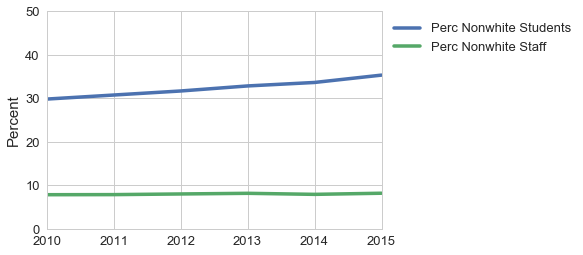

In [16]:
sns.set_style("whitegrid")
ax = year_grouped[['Year', 'Perc Nonwhite Students', 'Perc Nonwhite Staff']].set_index('Year').plot(linewidth=3.5)
ax.set_ylim(ymin = 0, ymax = 50)
ax.set_ylabel('Percent', fontsize=15)
ax.set_xlabel("")
ax.tick_params(labelsize=13)
ax.legend(bbox_to_anchor=(1.6,1), loc="upper right", prop={'size': 13});

Since less than 10% of staff members in Massachusetts schools report as nonwhite, we decided not to differentiate between different nonwhite ethnic and racial groups in our analysis.

### What is the breakdown of staff members of color within different school roles in Massachusetts?

We explored the average percent of nonwhite staff in every job category from 2010 to 2015. Although nonwhite staff members comprised 8% of school employees on average, a higher percent of nonwhite employees are paraprofessionals or administrative support (office managers or clerks) than teachers. We were interested in the fact that 10.8% of school leaders (principals or vice-principals) report as nonwhite. We wanted to explore this as a potential contributing factor to schools that have higher rates of staff members of color, as Massachusetts school leaders can often be the decision makers for hiring and school culture. 

In [17]:
df_jobs_grouped = df.groupby("Job Category").sum()[["Nonwhite (Num Staff)", "Total Staff"]]
df_jobs_grouped["% Nonwhite Staff"] = round(df_jobs_grouped["Nonwhite (Num Staff)"] / df_jobs_grouped["Total Staff"] * 100, 2)
df_jobs_grouped.reset_index()

,Job Category,Nonwhite (Num Staff),Total Staff,% Nonwhite Staff
0,Administrative Support,3193.9,33462.1,9.54
1,All Staff,53788.7,672689.1,8.00
2,District Leaders,154.4,2115.9,7.30
3,Health,507.6,10840.0,4.68
4,Paraprofessionals,15512.2,132788.5,11.68
5,Related Service Providers,678.8,19189.8,3.54
6,School Leaders,2716.3,25111.6,10.82
7,Student Support,3058.4,37248.8,8.21
8,Teachers,27975.7,412173.0,6.79


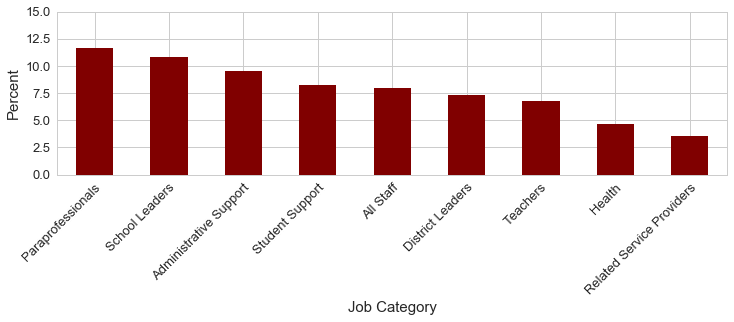

In [18]:
sns.set_style("whitegrid")
job = df_jobs_grouped["% Nonwhite Staff"].sort_values(ascending = False).plot(kind = "bar", color = "maroon", figsize = (12, 3))
job.set_ylim(ymin = 0, ymax = 15)
job.set_ylabel('Percent', fontsize=15)
job.tick_params(labelsize=13)
job.set_xlabel("Job Category", fontsize = 15)
job.set_xticklabels(job.get_xticklabels(),rotation=45,ha="right",rotation_mode='anchor');

## What characteristics do schools with high percentages of nonwhite staff members share?

### Is there a correlation between the percent of nonwhite students and percent of nonwhite staff in schools?

One of our hypotheses is that schools with higher percentages of nonwhite students will also have higher percentages of nonwhite staff. We looked at the correlation between percent of nonwhite students and percent of nonwhite staff in schools for each year between 2010 and 2015:

In [19]:
df['Perc Nonwhite Students'] = df['Nonwhite (Num Stu)'] / df['Total Students'] * 100
df['Perc Nonwhite Staff'] = df['Nonwhite (Num Staff)'] / df['Total Staff'] * 100

In [20]:
all_staff_mask = df["Job Category"] == "All Staff"
df_staff = df[all_staff_mask]
df_staff.head()

,Org Code,Org Name,Org Type,Year,Job Category,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff,Zip Code,Perc Nonwhite Students,Perc Nonwhite Staff
0,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2010,All Staff,913.0,1426,3.0,145.7,01606,64.025245,2.059025
9,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2011,All Staff,941.0,1426,4.0,151.7,01606,65.988780,2.636783
18,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2012,All Staff,963.0,1426,6.6,146.3,01606,67.531557,4.511278
27,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2013,All Staff,995.0,1426,7.5,154.3,01606,69.775596,4.860661
36,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2014,All Staff,1051.0,1426,7.6,157.3,01606,73.702665,4.831532


We saw that the correlation coefficient, while over .70 each year, has declined between 2010 and 2015. We also know that the current percent of students of color in MA schools is closer to the 2015 number than the 2010 number. For this reason, we continued our analysis with just 2015 data to see what other factors are associated with higher rates of nonwhite staff.

2010 rvalue: 0.777208556815 | pvalue: 0.0
2011 rvalue: 0.779424281375 | pvalue: 0.0
2012 rvalue: 0.755003345197 | pvalue: 2.7963636805e-316
2013 rvalue: 0.746471159142 | pvalue: 1.15225372594e-310
2014 rvalue: 0.716297195369 | pvalue: 3.22437633099e-279
2015 rvalue: 0.707250395781 | pvalue: 1.54131338763e-273


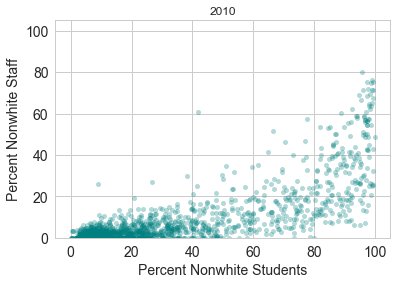

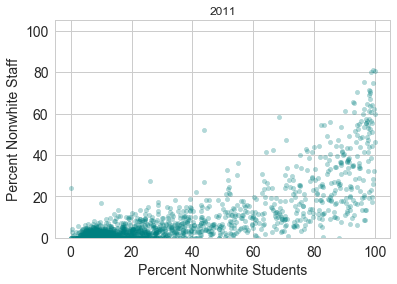

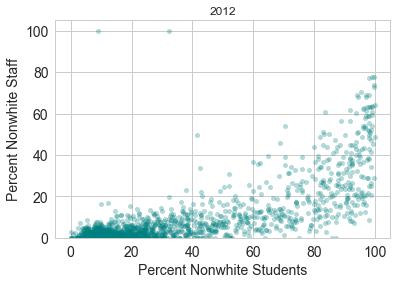

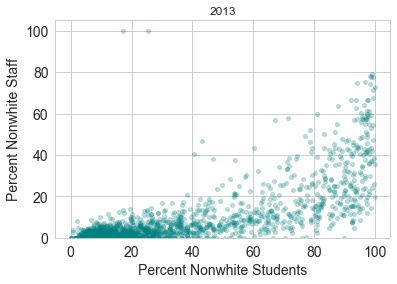

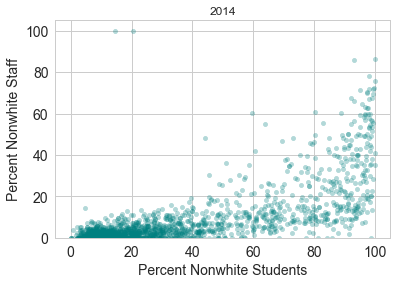

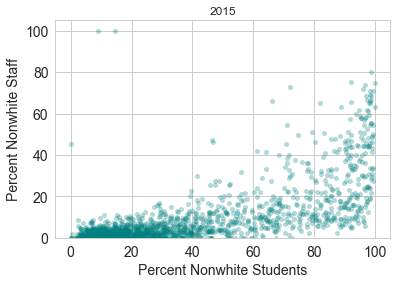

In [21]:
years = list(set(df_staff["Year"]))

for y in years:
    y_mask = df_staff["Year"] == y
    df_yr = df_staff[y_mask]
    r = stats.pearsonr(df_yr["Perc Nonwhite Students"], df_yr["Perc Nonwhite Staff"])
    p = df_yr.plot("Perc Nonwhite Students", "Perc Nonwhite Staff", kind = "scatter", color = 'teal', alpha = 0.3, title = y, fontsize = 14)
    p.set_xlabel('Percent Nonwhite Students', fontsize=14)
    p.set_ylabel('Percent Nonwhite Staff', fontsize=14)
    p.set_ylim(ymin = 0, ymax = 105)
    print(y, "rvalue:", r[0],"|", "pvalue:", r[1])
    p

In [22]:
mask_15 = df_staff["Year"] == 2015
df_staff_15 = df_staff[mask_15]
df_staff_15.head()

,Org Code,Org Name,Org Type,Year,Job Category,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff,Zip Code,Perc Nonwhite Students,Perc Nonwhite Staff
45,4450105,Abby Kelley Foster Charter Public (District): ...,Charter School,2015,All Staff,1071.0,1428,7.6,163.6,01606,75.000000,4.645477
99,10505,Abington: Abington High,Public School,2015,All Staff,55.0,477,3.0,59.5,02351,11.530398,5.042017
153,10405,Abington: Abington Middle School,Public School,2015,All Staff,28.0,305,1.0,37.0,02351,9.180328,2.702703
207,10015,Abington: Woodsdale Elementary School,Public School,2015,All Staff,26.0,330,1.0,32.1,02351,7.878788,3.115265
261,4120530,Academy Of the Pacific Rim Charter Public (Dis...,Charter School,2015,All Staff,437.0,519,10.0,55.5,02136,84.200385,18.018018


Before running our regressions, we looked at a few other factors that we believed could have an impact on the percent of staff members of color in a school.

### School leaders of color

To look at the relationship between the percent of nonwhite staff and the presence of a nonwhite school leader, we made a school leader True/False indicator in our data frame. 

In [23]:
sl_mask = df["Year"] == 2015
sl_mask &= df["Job Category"] == "School Leaders"
school_leaders = df[sl_mask]

In [24]:
school_leaders["Nonwhite Leader"] = school_leaders['Perc Nonwhite Staff'] > 0.0

C:\Users\jillk\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
school_leaders = school_leaders[["Org Code","Nonwhite Leader"]].set_index("Org Code")
df_staff_15 = df_staff_15.set_index("Org Code")
df_staff_15 = df_staff_15.join(school_leaders)
df_staff_15["Nonwhite Leader"] = df_staff_15["Nonwhite Leader"].fillna(0)

We saw that schools with a nonwhite leader had a higher median rate of nonwhite staff than schools without a nonwhite leader, but we wanted more information about student demographics in each school.  

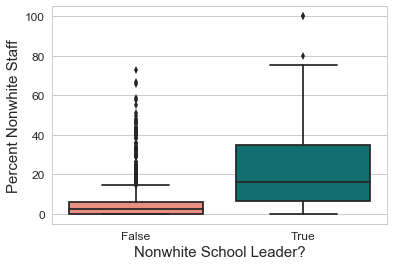

In [26]:
sl = sns.boxplot(x="Nonwhite Leader", y="Perc Nonwhite Staff", data=df_staff_15, palette = ["salmon", "teal"])
sl.set_ylabel('Percent Nonwhite Staff', fontsize=15)
sl.tick_params(labelsize=12)
sl.set_xlabel("Nonwhite School Leader?", fontsize = 15);

When we updated our scatterplot to show schools with and without a leader of color, the trend line for schools with a nonwhite leader had a steeper slope than schools with all white leaders.

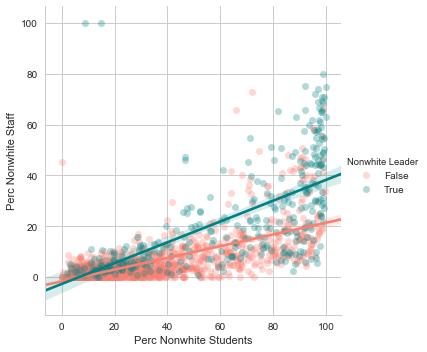

In [27]:
sc = sns.lmplot(x = "Perc Nonwhite Students", y = "Perc Nonwhite Staff", data = df_staff_15, hue="Nonwhite Leader", palette = ["salmon", "teal"], scatter_kws = {"alpha" : 0.3,})

### Public v. Charter Schools

We looked at school type as a contributor to the percentage of nonwhite staff in schools next, because many Massachusetts charter schools serve students of color. In a boxplot, we saw that charter schools have a higher median percentage of nonwhite staff. However, it is not possible to tell whether this is due to the school type or factors such as the location of the school. As the table below shows, there are many more students and staff members in traditional public schools versus charters. We decided to include Org Type in our regression for further exploration.

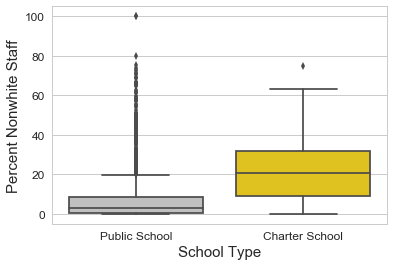

In [28]:
sl = sns.boxplot(x="Org Type", y="Perc Nonwhite Staff", data=df_staff_15, palette = ["silver", "gold"], order = ["Public School", "Charter School"])
sl.set_ylabel('Percent Nonwhite Staff', fontsize=15)
sl.tick_params(labelsize=12)
sl.set_xlabel("School Type", fontsize = 15);

In [29]:
population = df_staff_15.groupby(["Org Type"]).sum()[["Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "Total Staff"]]
population = population.reset_index()

In [30]:
population["Perc Nonwhite Students"] = round(population["Nonwhite (Num Stu)"] / population["Total Students"] * 100, 1)
population["Perc Nonwhite Staff"] = round(population["Nonwhite (Num Staff)"] / population["Total Staff"] *100, 1)
population

,Org Type,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff,Perc Nonwhite Students,Perc Nonwhite Staff
0,Charter School,22936.0,35388,1018.8,4734.7,64.8,21.5
1,Public School,314849.0,902171,8607.9,112996.9,34.9,7.6


### American Community Survey Data

Before running our regression, we brought several ACS variables into our data frame: median income, percent of households in poverty with an 18-year-old child or younger, percent high school graduates, percent college graduates, and percent nonwhite residents by zip code. We believed these characteristics could contribute to the rates of nonwhite staff members working in schools in certain zip codes.

In [31]:
acs = pd.read_csv("../acs/acs_indicators_by_zip.csv", converters={'Zip Code': str}, usecols = ["Zip Code", "Median Income", "Percent Poverty", "% HS Graduates", "% College Graduates", "Zip Perc White"])

We had to remove the dashes from missing data fields in the ACS dataframe before moving forward with our analysis.

In [32]:
acs = acs.replace('-', np.NaN)
acs["Median Income"] = acs["Median Income"].apply(pd.to_numeric, errors='coerce')
acs["Percent Poverty"] = acs["Percent Poverty"].apply(pd.to_numeric, errors='coerce')
acs["Percent Nonwhite Residents"] = 100 - acs["Zip Perc White"]

In [33]:
acs = acs.set_index("Zip Code")
acs.head()

,Median Income,Percent Poverty,% HS Graduates,% College Graduates,Zip Perc White,Percent Nonwhite Residents
Zip Code,,,,,,
01001,60161.0,7.1,91.5,28.0,91.8,8.2
01002,50540.0,14.7,95.6,68.0,78.4,21.6
01005,68786.0,2.6,95.7,24.0,97.3,2.7
01007,76881.0,8.5,92.4,42.0,94.9,5.1
01010,87961.0,0.0,94.0,41.6,100.0,0.0


In [34]:
df_staff_15 = df_staff_15.reset_index().set_index("Zip Code")
df_staff_15 = df_staff_15.join(acs)
df_staff_15.head()

,Org Code,Org Name,Org Type,Year,Job Category,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff,Perc Nonwhite Students,Perc Nonwhite Staff,Nonwhite Leader,Median Income,Percent Poverty,% HS Graduates,% College Graduates,Zip Perc White,Percent Nonwhite Residents
Zip Code,,,,,,,,,,,,,,,,,,
01001,50003,Agawam: Agawam Early Childhood Center,Public School,2015,All Staff,11.0,165,2.0,43.5,6.666667,4.597701,False,60161.0,7.1,91.5,28.0,91.8,8.2
01001,50505,Agawam: Agawam High,Public School,2015,All Staff,141.0,1280,1.1,138.2,11.015625,0.795948,False,60161.0,7.1,91.5,28.0,91.8,8.2
01001,50303,Agawam: Roberta G. Doering School,Public School,2015,All Staff,78.0,590,3.2,80.5,13.220339,3.975155,False,60161.0,7.1,91.5,28.0,91.8,8.2
01001,50020,Agawam: Benjamin J Phelps,Public School,2015,All Staff,54.0,406,0.2,52.1,13.300493,0.383877,False,60161.0,7.1,91.5,28.0,91.8,8.2
01001,50030,Agawam: James Clark School,Public School,2015,All Staff,50.0,332,0.1,54.2,15.060241,0.184502,False,60161.0,7.1,91.5,28.0,91.8,8.2


### 'In Boston' Indicator

Boston is much less white than Massachusetts suburbs, so we believe that schools in the city are more likely to have staff members of color. We included zip code as a categorical variable the first time we ran our regression, but including the 428 distinct zip codes in our model seemed excessive. We noticed that many of the zip codes with the highest coefficients were those in Boston, so we created an 'In Boston' indicator for our model instead.

In [35]:
boston_zip = ['02111', '02113', '02115', '02116', '02118', '02119', '02120', '02121', '02122', '02124', '02125', '02126', '02127',
'02128', '02129', '02130', '02131', '02132', '02134', '02135', '02136', '02215']

boston_flag = ["Boston" for x in boston_zip]
boston = pd.DataFrame({'Zip Code': boston_zip, 'In Boston': boston_flag})

In [36]:
df_staff_15 = df_staff_15.reset_index()

In [37]:
df_staff_15 = pd.merge(df_staff_15, boston, how = "left", on = "Zip Code")

In [38]:
df_staff_15["In Boston"] = df_staff_15["In Boston"].fillna("Not Boston")
df_staff_15["In Boston"] = pd.Categorical(df_staff_15["In Boston"], categories=["Not Boston", "Boston"], ordered=True)

Boston schools tend to have higher percentages of nonwhite students and staff members than schools outside of the city. That said, the median percent of nonwhite students enrolled in Boston schools is much higher than the median percent of nonwhite staff members in Boston schools.

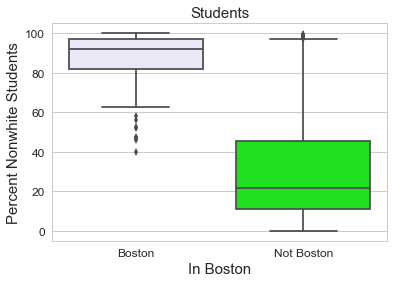

In [39]:
boston = sns.boxplot(x="In Boston", y="Perc Nonwhite Students", data=df_staff_15, palette = ["lavender", "lime"], order = ["Boston", "Not Boston"])
boston.set_ylabel('Percent Nonwhite Students', fontsize=15)
boston.set_title('Students', fontsize=15)
boston.tick_params(labelsize=12)
boston.set_xlabel("In Boston", fontsize = 15);

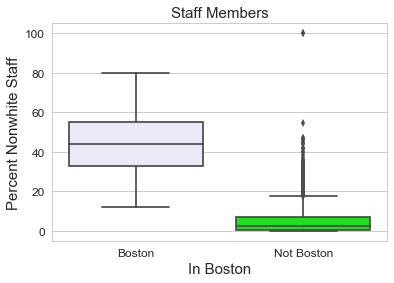

In [40]:
boston = sns.boxplot(x="In Boston", y="Perc Nonwhite Staff", data=df_staff_15, palette = ["lavender", "lime"], order = ["Boston", "Not Boston"])
boston.set_ylabel('Percent Nonwhite Staff', fontsize=15)
boston.tick_params(labelsize=12)
boston.set_title('Staff Members', fontsize=15)
boston.set_xlabel("In Boston", fontsize = 15);

### Regression: All Schools

Before running our regression for all schools in 2015, we dropped 6 records that were missing ACS data:

In [41]:
df_staff_15 = df_staff_15.dropna(subset = ['Percent Poverty', '% HS Graduates', 'Percent Nonwhite Residents'])

Our first regression had an R-squared of 0.749. We removed % College Graduates and Median Income variables, as both had high p-values and didn't contribute to our R-squared. 

The results show that several variables were significant: the presence of a nonwhite school leader, the location of a school in Boston, higher percentages of nonwhite students, higher student enrollment, and more residents of color in a zip code. The 'In Boston' indicator had the largest coefficient by far, but we were particularly interested in the size of the coefficient for the nonwhite school leader indicator. 

In [42]:
ols = smf.ols(formula = "nw_staff ~ nw_stu + nw_sl + org_type + in_boston + perc_pov + hs_grad + total_stu + zip_nonwhite",
              data = df_staff_15.rename(columns = {"Perc Nonwhite Students" : "nw_stu", 
                                          "Perc Nonwhite Staff"  : "nw_staff",
                                                   "In Boston": "in_boston",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Nonwhite Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                    "Percent Nonwhite Residents": "zip_nonwhite"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nw_staff   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     666.1
Date:                Fri, 19 Jan 2018   Prob (F-statistic):               0.00
Time:                        11:13:35   Log-Likelihood:                -5991.2
No. Observations:                1797   AIC:                         1.200e+04
Df Residuals:                    1788   BIC:                         1.205e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -8.4334      3.601     -2.342      0.019     -15.496      -1.371
nw_sl[T.True]                 5.5088      0.493     11.170      0.000       4.542       6.476
org_type[T.Public School]    -1.1384      0.842     -1.352      0.177      -2.790       0.513
in_boston[T.Boston]          25.0702      0.755     33.194      0.000      23.589      26.551
nw_stu                        0.1395      0.012     11.770      0.000       0.116       0.163
perc_pov                      0.0615      0.026      2.392      0.017       0.011       0.112
hs_grad                       0.0973      0.036      2.740      0.006       0.028       0.167
total_stu                    -0.0018      0.000     -3.750      0.000      -0.003      -0.001
zip_nonwhite                  0.0737      0.018      4.087      0.000       0.038       0.109
==============================================================================
Omnibus:                     1502.878   Durbin-Watson:                   1.461
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           130312.316
Skew:                           3.378   Prob(JB):                         0.00
Kurtosis:                      44.167   Cond. No.                     1.43e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

When we looked at our residuals, we noticed that they become more spread out for schools that are over 50% nonwhite.

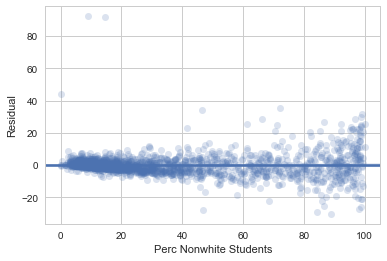

In [43]:
re = sns.regplot(x = df_staff_15["Perc Nonwhite Students"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.2});

Before we ran a regression for schools with a nonwhite student population over 50%, we looked at the 3 schools with residuals over 40. These three schools are extremely small, and two of them (which are housed in the same building) appear to have a data quality issue, reporting only 0.1 total staff members in 2015.  

In [44]:
df_staff_15["Residuals"] = model.resid
outlier_mask = df_staff_15["Residuals"] > 40
df_staff_o = df_staff_15[outlier_mask]
df_staff_o

,Zip Code,Org Code,Org Name,Org Type,Year,Job Category,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff,...,Perc Nonwhite Staff,Nonwhite Leader,Median Income,Percent Poverty,% HS Graduates,% College Graduates,Zip Perc White,Percent Nonwhite Residents,In Boston,Residuals
252,01257,7650015,Southern Berkshire: Monterey,Public School,2015,All Staff,0.0,6,1.0,2.2,...,45.454545,False,47167.0,27.6,90.5,33.2,97.5,2.5,Not Boston,44.346701
325,01440,7550515,Ralph C Mahar: Pathways Early College Innovati...,Public School,2015,All Staff,3.0,34,0.1,0.1,...,100.000000,True,43818.0,26.8,84.3,16.4,90.0,10.0,Not Boston,92.301124
326,01440,7550525,Ralph C Mahar: The Gateway to College,Public School,2015,All Staff,10.0,68,0.1,0.1,...,100.000000,True,43818.0,26.8,84.3,16.4,90.0,10.0,Not Boston,91.540076


### Regression: Schools with >50% students of color

We reran our regression for schools with over 50% students of color to see if the same variables contribute to the percentage of nonwhite staff. Our nonwhite school leader variable remained significant, and the percent of college graduates in a zip code became significant. Interestingly, the coefficient for "Public School" changed from negative to positive, but the p-value is high. The 'In Boston' indicator still had the highest coefficient, so we decided to run our regression for just schools in Boston next. 

In [45]:
overhalf_mask = df_staff_15["Perc Nonwhite Students"] > 50.0
df_overhalf = df_staff_15[overhalf_mask]

In [46]:
ols = smf.ols(formula = "nw_staff ~ nw_stu + nw_sl + org_type + in_boston + college_grad + total_stu + zip_nonwhite",
              data = df_overhalf.rename(columns = {"Perc Nonwhite Students" : "nw_stu", 
                                          "Perc Nonwhite Staff"  : "nw_staff",
                                                   "In Boston": "in_boston",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Nonwhite Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                   "% College Graduates": "college_grad",
                                                    "Percent Nonwhite Residents": "zip_nonwhite"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nw_staff   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     178.8
Date:                Fri, 19 Jan 2018   Prob (F-statistic):          1.15e-130
Time:                        11:13:37   Log-Likelihood:                -1827.8
No. Observations:                 499   AIC:                             3672.
Df Residuals:                     491   BIC:                             3705.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -20.8482      3.650     -5.712      0.000     -28.019     -13.677
nw_sl[T.True]                 5.3816      0.978      5.502      0.000       3.460       7.303
org_type[T.Public School]     1.5956      1.557      1.025      0.306      -1.463       4.655
in_boston[T.Boston]          20.9858      1.265     16.593      0.000      18.501      23.471
nw_stu                        0.3105      0.038      8.170      0.000       0.236       0.385
college_grad                  0.1737      0.029      5.971      0.000       0.117       0.231
total_stu                    -0.0027      0.001     -2.492      0.013      -0.005      -0.001
zip_nonwhite                  0.1315      0.031      4.244      0.000       0.071       0.192
==============================================================================
Omnibus:                       22.914   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.184
Skew:                           0.409   Prob(JB):                     2.79e-07
Kurtosis:                       3.884   Cond. No.                     5.95e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Regression: Boston

When we ran the regression for just schools in Boston, our r-squared dropped to 0.493. The p-value for the presence of a nonwhite school leader changed from 0.000 to 0.019. The 'Public School' indicator, however, became significant and had a coefficient of 16.1. This was a change that we wanted to explore further. 

In [47]:
boston_mask = df_staff_15["In Boston"] == "Boston"
boston_15 = df_staff_15[boston_mask]

In [48]:
ols = smf.ols(formula = "nw_staff ~ nw_stu + nw_sl + org_type + college_grad + total_stu + zip_nonwhite",
              data = boston_15.rename(columns = {"Perc Nonwhite Students" : "nw_stu", 
                                          "Perc Nonwhite Staff"  : "nw_staff",
                                                   "In Boston": "in_boston",
                                                   "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Nonwhite Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                   "% College Graduates": "college_grad",
                                                    "Percent Nonwhite Residents": "zip_nonwhite"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nw_staff   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     21.04
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           3.87e-17
Time:                        11:13:37   Log-Likelihood:                -520.51
No. Observations:                 137   AIC:                             1055.
Df Residuals:                     130   BIC:                             1075.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -38.9830      8.844     -4.408      0.000     -56.480     -21.486
nw_sl[T.True]                 5.3084      2.233      2.377      0.019       0.890       9.727
org_type[T.Public School]    16.1356      2.723      5.926      0.000      10.749      21.522
nw_stu                        0.4013      0.080      5.013      0.000       0.243       0.560
college_grad                  0.3957      0.082      4.812      0.000       0.233       0.558
total_stu                    -0.0071      0.003     -2.293      0.023      -0.013      -0.001
zip_nonwhite                  0.3595      0.070      5.159      0.000       0.222       0.497
==============================================================================
Omnibus:                        6.751   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                6.640
Skew:                           0.417   Prob(JB):                       0.0362
Kurtosis:                       3.684   Cond. No.                     5.28e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.28e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

When we examined the residuals for Boston, we saw a cluster of schools with nonwhite student enrollment over 90%. We returned to this group of schools with >90% nonwhite student enrollment in and outside of Boston after looking at the differences between Boston's charter and traditional public schools.

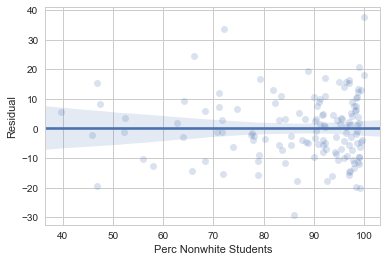

In [49]:
re = sns.regplot(x = boston_15["Perc Nonwhite Students"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.2});

### Charter versus Public Schools in Boston

The median percent of staff members of color in Boston public schools is over 40% higher than the median percent of nonwhite staff in all public schools across Massachusetts. In Boston, traditional public schools have a higher median percent of nonwhite staff than charters, even though the median percent of nonwhite students enrolled in charter schools is higher. This helped us understand the change in our Public School variable when we examined just the schools in Boston.

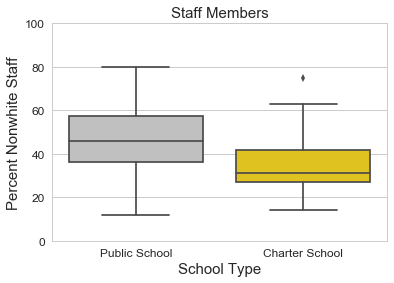

In [50]:
sl = sns.boxplot(x="Org Type", y="Perc Nonwhite Staff", data=boston_15, palette = ["silver", "gold"])
sl.set_ylabel('Percent Nonwhite Staff', fontsize=15)
sl.set_title('Staff Members', fontsize=15)
sl.tick_params(labelsize=12)
sl.set_ylim(ymin = 0, ymax = 100)
sl.set_xlabel("School Type", fontsize = 15);

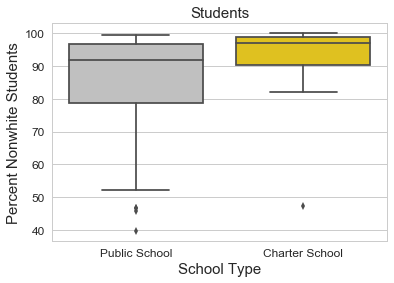

In [51]:
sl = sns.boxplot(x="Org Type", y="Perc Nonwhite Students", data=boston_15, palette = ["silver", "gold"])
sl.set_ylabel('Percent Nonwhite Students', fontsize=15)
sl.set_title('Students', fontsize=15)
sl.tick_params(labelsize=12)
sl.set_xlabel("School Type", fontsize = 15);

We then grouped our dataframe with all Massachusetts schools in 2015 by type and location in or outside of Boston. To account for the fact that charters enroll fewer students and employ fewer staff members, we created a measure called "Nonwhite Student to Staff Ratio" which shows the average number of nonwhite students for every nonwhite staff member.

We thought it was interesting that, on average, there is a similar number of nonwhite students to every nonwhite staff member in Boston charters and traditional public schools. We still had questions about the variation in rates of nonwhite staff members in school with over 90% nonwhite students, so we explored this subset of data next.

In [52]:
ally = df_staff_15.groupby(["In Boston", "Org Type"]).sum()[["Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "Total Staff"]]
ally = ally.reset_index()

In [53]:
ally['Nonwhite Student to Staff Ratio'] = round(ally["Nonwhite (Num Stu)"] / ally["Nonwhite (Num Staff)"], 2)
ally["Perc Nonwhite Students"] = round(ally["Nonwhite (Num Stu)"] / ally["Total Students"] * 100, 1)
ally["Perc Nonwhite Staff"] = round(ally["Nonwhite (Num Staff)"] / ally["Total Staff"] *100, 1)
ally = ally[["In Boston", "Org Type", "Nonwhite Student to Staff Ratio", "Perc Nonwhite Students", "Perc Nonwhite Staff", "Nonwhite (Num Stu)", "Total Students", "Nonwhite (Num Staff)", "Total Staff"]]
ally

,In Boston,Org Type,Nonwhite Student to Staff Ratio,Perc Nonwhite Students,Perc Nonwhite Staff,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff
0,Not Boston,Charter School,26.25,55.1,16.5,14087.0,25552,536.7,3255.1
1,Not Boston,Public School,46.49,31.8,5.4,269004.0,847046,5786.5,106525.5
2,Boston,Charter School,18.37,90.7,32.9,8374.0,9233,455.9,1387.3
3,Boston,Public School,16.15,85.9,45.6,45496.0,52981,2816.5,6179.4


### Regression: Schools with >90% students of color

There were 163 schools across 41 zip codes in 2015 with nonwhite student populations greater than 90%.

In [54]:
overninety_mask = df_staff_15["Perc Nonwhite Students"] > 90.0
df_overninety = df_staff_15[overninety_mask]

In [55]:
df_overninety.head()

,Zip Code,Org Code,Org Name,Org Type,Year,Job Category,Nonwhite (Num Stu),Total Students,Nonwhite (Num Staff),Total Staff,...,Perc Nonwhite Staff,Nonwhite Leader,Median Income,Percent Poverty,% HS Graduates,% College Graduates,Zip Perc White,Percent Nonwhite Residents,In Boston,Residuals
69,01040,1370040,Holyoke: Kelly Elementary,Public School,2015,All Staff,571.0,586,20.5,82.9,...,24.728589,False,36608.0,38.4,77.3,23.4,82.1,17.9,Not Boston,10.528501
73,01040,1370025,Holyoke: Morgan Full Service Community School,Public School,2015,All Staff,391.0,399,13.0,54.4,...,23.897059,True,36608.0,38.4,77.3,23.4,82.1,17.9,Not Boston,3.782753
74,01040,1370030,Holyoke: William R. Peck School,Public School,2015,All Staff,345.0,371,31.9,90.4,...,35.287611,True,36608.0,38.4,77.3,23.4,82.1,17.9,Not Boston,15.822204
75,01040,1370605,Holyoke: Wm J Dean Vocational Technical High,Public School,2015,All Staff,381.0,403,22.0,85.1,...,25.851939,True,36608.0,38.4,77.3,23.4,82.1,17.9,Not Boston,6.226554
76,01040,4530005,Holyoke Community Charter (District): Holyoke ...,Charter School,2015,All Staff,659.0,704,30.4,87.9,...,34.584755,True,36608.0,38.4,77.3,23.4,82.1,17.9,Not Boston,14.479242


The presence of a nonwhite school leader and our In Boston and Public School indicators all were significant and had positive coefficients when we ran our regression. The school leader coefficient rose from 5 to 8 in this iteration of our model. 

In [56]:
ols = smf.ols(formula = "nw_staff ~ nw_stu + nw_sl + org_type + in_boston + college_grad + total_stu + zip_nonwhite",
              data = df_overninety.rename(columns = {"Perc Nonwhite Students" : "nw_stu", 
                                          "Perc Nonwhite Staff"  : "nw_staff",
                                                   "In Boston": "in_boston",
                                                   "Zip Code" : "zip",
                                                     "Org Type": "org_type",
                                                   "Total Students": "total_stu",
                                                   "Median Income" : "med_income",
                                                    "Nonwhite Leader": "nw_sl",
                                                   "Percent Poverty": "perc_pov",
                                                   "% HS Graduates": "hs_grad",
                                                   "% College Graduates": "college_grad",
                                                    "Percent Nonwhite Residents": "zip_nonwhite"}))
model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               nw_staff   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     45.83
Date:                Fri, 19 Jan 2018   Prob (F-statistic):           1.13e-34
Time:                        11:13:39   Log-Likelihood:                -621.55
No. Observations:                 163   AIC:                             1259.
Df Residuals:                     155   BIC:                             1284.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -76.0157     34.421     -2.208      0.029    -144.011      -8.020
nw_sl[T.True]                 8.3504      2.091      3.994      0.000       4.220      12.481
org_type[T.Public School]     5.3505      2.357      2.270      0.025       0.694      10.007
in_boston[T.Boston]          16.9227      3.274      5.168      0.000      10.454      23.391
nw_stu                        0.8631      0.374      2.310      0.022       0.125       1.601
college_grad                  0.2831      0.098      2.876      0.005       0.089       0.477
total_stu                    -0.0132      0.004     -3.413      0.001      -0.021      -0.006
zip_nonwhite                  0.1851      0.081      2.272      0.024       0.024       0.346
==============================================================================
Omnibus:                        0.374   Durbin-Watson:                   1.796
Prob(Omnibus):                  0.829   Jarque-Bera (JB):                0.528
Skew:                           0.032   Prob(JB):                        0.768
Kurtosis:                       2.728   Cond. No.                     2.11e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Next, we grouped schools based on whether they were above or below the 0-line on our residuals plot to examine the difference in staffing rates. We called the group of schools with residuals greater than 0 the 'High' group and the group of schools with residuals less than 0 the 'Low' group. 

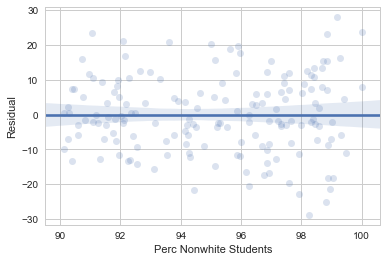

In [57]:
re = sns.regplot(x = df_overninety["Perc Nonwhite Students"], y = pd.Series(model.resid, name = "Residual"), scatter_kws = {"alpha" : 0.2});

In [58]:
df_overninety["Residuals"] = model.resid
df_overninety["Residuals Group"] = np.where(df_overninety["Residuals"] > 0, "High", "Low")

C:\Users\jillk\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\jillk\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [59]:
df_overninety.to_csv("schools_w_residuals.csv")

We thought the difference in average number of nonwhite staff between groups was pretty interesting. Outside of Boston, schools in the 'High' group had over double the number of nonwhite staff than schools in the 'Low' group on average. In Boston, the average number of nonwhite staff was 1.5x greater in the 'High' group.

In [1336]:
avg_size = df_overninety.groupby(["In Boston", "Residuals Group"]).mean()[["Total Students", "Total Staff", "Perc Nonwhite Staff", "Nonwhite (Num Staff)", "Nonwhite (Num Stu)", "Perc Nonwhite Students", "Residuals"]]
avg_size

Total Students  Total Staff  Perc Nonwhite Staff  \
In Boston  Residuals Group                                                     
Not Boston High                 501.138889    63.752778            29.445024   
           Low                  502.363636    60.047727            13.452942   
Boston     High                 425.300000    52.070000            60.393760   
           Low                  460.186047    59.251163            40.008038   

                            Nonwhite (Num Staff)  Nonwhite (Num Stu)  \
In Boston  Residuals Group                                             
Not Boston High                        17.838889          471.166667   
           Low                          8.115909          472.659091   
Boston     High                        30.372500          406.050000   
           Low                         23.374419          440.930233   

                            Perc Nonwhite Students  Residuals  
In Boston  Residuals Group                                     
Not Boston High                          94.448927   9.266342  
           Low                           94.426566  -7.581553  
Boston     High                          95.892140   9.613630  
           Low                           95.735649  -8.942912

It was interesting that schools serving similar numbers of nonwhite students, oftentimes in the same neighborhood, could have such different staff compositions. Particularly outside of Boston, it seems feasible that students in a 'low residuals group' school might not ever have a touchpoint with a staff member of color during the day. This brought us to our final question: does the staff composition in a school with a high nonwhite student population even matter? 

## Do student outcomes vary in schools with different rates of nonwhite staff members?

We used our dataset of 163 schools with nonwhite student enrollment over 90% to examine this question. These schools shared many characteristics, but the number of staff members of color in their buildings varied. We kept schools in their 'High' and 'Low' residual groups and examined several student success measures. We knew this sample size was too small to lead to any formal conclusions, but we thought we could gain some ideas for future investigation.

We used attendance rates, school stability (how many students stay in a school for a full year), and percent of students receiving in or out of school suspension as our measures. We first merged these measures into one dataframe.

In [60]:
attendance = pd.read_csv("../student_data/student_attendance_all.csv")
mobility = pd.read_csv("../student_data/student_mobility_all.csv", usecols = ["Org Code", "% Stability", "Year"])
suspensions = pd.read_csv("../student_data/student_suspensions_all.csv", usecols = ["Org Code", "% In-School Suspension", "% Out-of-School Suspension", "Students", "Year"])
tests = pd.read_csv("../tests/tests_all.csv")

In [61]:
indicators = pd.merge(attendance, mobility, how = "left", on = ["Org Code", "Year"])
indicators = pd.merge(indicators, suspensions, how = "left", on = ["Org Code", "Year"])
indicators = pd.merge(indicators, tests, how = "left", on = ["Org Code", "Year"])

In [62]:
indicators = indicators.fillna(0)

In [63]:
indicators.head()

,Org Code,Attendance Rate,Average # of days absent,Absent 10 or more days,Chronically Absent (10% or more),Year,Retention Rate,% Stability,% In-School Suspension,% Out-of-School Suspension,Students,Perc Proficient (ELA),Students (ELA),CPI (ELA),SGP (ELA),Perc Proficient (Math),Students (Math),CPI (Math),SGP (Math),Test
0,100055,97.1,4.7,12.9,3.4,2011,1.4,92.7,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0
1,2770020,93.9,9.6,39.8,20.4,2011,0.3,88.6,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0
2,350020,92.9,12.3,50.5,23.3,2011,2.4,89.3,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0
3,1590017,96.2,6.8,23.4,6.5,2011,0.0,97.7,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0
4,950140,94.7,9.2,39.9,12.5,2011,0.0,95.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0


In [64]:
df_on = pd.merge(df_overninety, indicators, how = "left", on = ["Org Code", "Year"])

In [65]:
df_on["Attendance Rate"] = df_on["Attendance Rate"].astype(float)
df_on["Retention Rate"] = df_on["Retention Rate"].astype(float)
df_on["Number Students OSS"] = df_on["% Out-of-School Suspension"]/100*df_on["Students"]
df_on["Number Students ISS"] = df_on["% In-School Suspension"]/100*df_on["Students"]

We looked at the differences in the 'High' and 'Low' groups in and outside of Boston first. Schools in the 'Low' groups had higher stability and better attendance metrics than schools in the 'High' groups. However, we found the differences in the number of students receiving in and out of school suspension interesting. In Boston, schools with higher than expected rates of nonwhite staff had a small average number and percent of students receiving suspensions. We weren't sure why the pattern was reversed outside of Boston, so we added Org Type to our next table:

In [66]:
boston_groups = df_on.groupby(["In Boston", "Residuals Group"]).mean()[["% Out-of-School Suspension", "Number Students OSS", "% In-School Suspension", "Number Students ISS", "Attendance Rate", "Chronically Absent (10% or more)", "% Stability"]]
boston_groups

% Out-of-School Suspension  Number Students OSS  \
In Boston  Residuals Group                                                    
Not Boston High                               7.233333            43.082528   
           Low                                5.297727            26.198841   
Boston     High                               4.580000            22.238475   
           Low                                7.918605            41.653349   

                            % In-School Suspension  Number Students ISS  \
In Boston  Residuals Group                                                
Not Boston High                           2.588889            13.947611   
           Low                            1.743182            10.197068   
Boston     High                           0.567500             2.630275   
           Low                            2.174419            11.578186   

                            Attendance Rate  Chronically Absent (10% or more)  \
In Boston  Residuals Group                                                      
Not Boston High                   90.338889                         24.708333   
           Low                    93.475000                         18.970455   
Boston     High                   90.870000                         26.635000   
           Low                    92.111628                         25.565116   

                            % Stability  
In Boston  Residuals Group               
Not Boston High               80.075000  
           Low                82.434091  
Boston     High               81.832500  
           Low                83.390698

When we added school type to our table, the story stays similar for Boston: schools in the 'High' group on average have fewer students receiving ISS and OSS. The trend appears to be reversed for both public and charter schools outside of Boston. 

In [1344]:
residuals_groups = df_on.groupby(["In Boston", "Org Type", "Residuals Group"]).mean()[["% Out-of-School Suspension", "Number Students OSS", "Number Students ISS", "% In-School Suspension", "Attendance Rate", "Chronically Absent (10% or more)", "% Stability"]]
residuals_groups

% Out-of-School Suspension  \
In Boston  Org Type       Residuals Group                               
Not Boston Charter School High                               6.692308   
                          Low                                0.000000   
           Public School  High                               7.539130   
                          Low                                5.550000   
Boston     Charter School High                               8.000000   
                          Low                               13.138462   
           Public School  High                               4.302703   
                          Low                                5.656667   

                                           Number Students OSS  \
In Boston  Org Type       Residuals Group                        
Not Boston Charter School High                       29.397308   
                          Low                         0.000000   
           Public School  High                       50.817652   
                          Low                        27.446405   
Boston     Charter School High                       20.311333   
                          Low                        54.308308   
           Public School  High                       22.394730   
                          Low                        36.169533   

                                           Number Students ISS  \
In Boston  Org Type       Residuals Group                        
Not Boston Charter School High                       18.556923   
                          Low                         0.000000   
           Public School  High                       11.342348   
                          Low                        10.682643   
Boston     Charter School High                        2.075333   
                          Low                        17.939000   
           Public School  High                        2.675270   
                          Low                         8.821833   

                                           % In-School Suspension  \
In Boston  Org Type       Residuals Group                           
Not Boston Charter School High                           3.492308   
                          Low                            0.000000   
           Public School  High                           2.078261   
                          Low                            1.826190   
Boston     Charter School High                           0.833333   
                          Low                            4.192308   
           Public School  High                           0.545946   
                          Low                            1.300000   

                                           Attendance Rate  \
In Boston  Org Type       Residuals Group                    
Not Boston Charter School High                   90.292308   
                          Low                    96.000000   
           Public School  High                   90.365217   
                          Low                    93.354762   
Boston     Charter School High                   94.200000   
                          Low                    92.553846   
           Public School  High                   90.600000   
                          Low                    91.920000   

                                           Chronically Absent (10% or more)  \
In Boston  Org Type       Residuals Group                                     
Not Boston Charter School High                                    22.046154   
                          Low                                      6.650000   
           Public School  High                                    26.213043   
                          Low                                     19.557143   
Boston     Charter School High                                    16.466667   
                          Low                                     21.807692   
           Public School  High                

In [1345]:
boston_mask = df_on["In Boston"] == "Boston"
df_on_boston = df_on[boston_mask]
df_on_notboston = df_on[~boston_mask]

Our final step was to plot the number of students suspended out-of-school by residual group and school type. Given the differences between the Boston and outside of Boston averages, we split the data up. 

In Boston, we see a number of charter and public schools in the 'Low' group with over 50 students suspended (the shape of this plot is similar when '% Out-of-School Suspensions' is on the y-axis). It's important to note that only 3 charter schools are in the 'High' group in Boston. 

Outside of Boston, there is one public school in the 'High' group that is a high outlier for students suspended, and the plot shows only 2 charter schools in the 'High' group. 

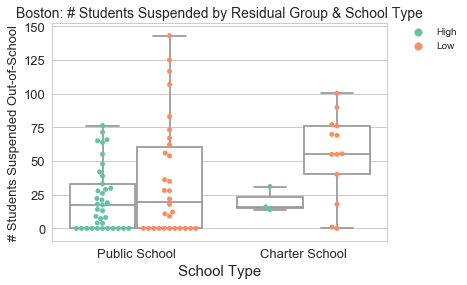

In [1346]:
ax = sns.boxplot(x="Org Type", y="Number Students OSS", hue="Residuals Group", data=df_on_boston, palette=["white", "white"])
ax = sns.swarmplot(x="Org Type", y="Number Students OSS", hue="Residuals Group", data=df_on_boston, palette="Set2", split=True)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2:4], labels[2:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('# Students Suspended Out-of-School', fontsize=13)
ax.set_title('Boston: # Students Suspended by Residual Group & School Type', fontsize=14)
ax.tick_params(labelsize=13)
ax.set_xlabel("School Type", fontsize = 15);

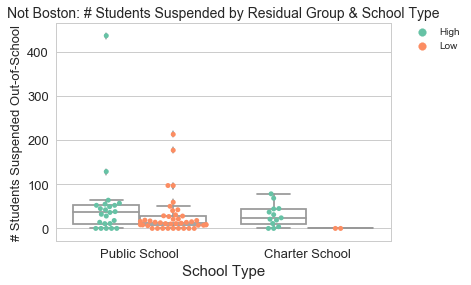

In [1347]:
ax = sns.boxplot(x="Org Type", y="Number Students OSS", hue="Residuals Group", data=df_on_notboston, palette=["white", "white"])
ax = sns.swarmplot(x="Org Type", y="Number Students OSS", hue="Residuals Group", data=df_on_notboston, palette="Set2", split=True)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2:4], labels[2:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('# Students Suspended Out-of-School', fontsize=13)
ax.set_title('Not Boston: # Students Suspended by Residual Group & School Type', fontsize=14)
ax.tick_params(labelsize=13)
ax.set_xlabel("School Type", fontsize = 15);

## Test Results

In [91]:
df_on["SGP (ELA)"] = df_on["SGP (ELA)"].apply(pd.to_numeric, errors='coerce')
df_on["SGP (Math)"] = df_on["SGP (Math)"].apply(pd.to_numeric, errors='coerce')

In [118]:
test_mask = df_on["Test"] == 0
sgpmath_mask = df_on["SGP (Math)"] == 0
sgpela_mask = df_on["SGP (ELA)"] == 0

In [104]:
df_tests = df_on[~test_mask]

In [119]:
df_tests = df_on[~sgpmath_mask]
df_tests = df_on[~sgpela_mask]

In [120]:
boston_tests = df_tests.groupby(["In Boston", "Residuals Group"]).mean()[["Perc Proficient (Math)", "CPI (Math)", "SGP (Math)", "Students (Math)", "Perc Proficient (ELA)", "CPI (ELA)", "SGP (ELA)", "Students (ELA)"]]
boston_tests

Perc Proficient (Math)  CPI (Math)  SGP (Math)  \
In Boston  Residuals Group                                                   
Not Boston High                          40.333333   68.253333   49.732143   
           Low                           36.350000   66.610000   43.437500   
Boston     High                          40.787879   70.687879   47.515625   
           Low                           39.500000   70.837500   52.576923   

                            Students (Math)  Perc Proficient (ELA)  CPI (ELA)  \
In Boston  Residuals Group                                                      
Not Boston High                   276.60000              47.833333  76.350000   
           Low                    251.52500              33.625000  68.150000   
Boston     High                   208.30303              48.818182  78.333333   
           Low                    201.80000              45.575000  76.652500   

                            SGP (ELA)  Students (ELA)  
In Boston  Residuals Group                             
Not Boston High             48.074074      278.833333  
           Low              45.512500      252.100000  
Boston     High             49.718750      207.909091  
           Low              50.179487      201.450000

In [121]:
boston_tests = df_tests.groupby(["Test", "In Boston", "Residuals Group"]).mean()[["Perc Proficient (Math)", "CPI (Math)", "SGP (Math)", "Students (Math)", "Perc Proficient (ELA)", "CPI (ELA)", "SGP (ELA)", "Students (ELA)"]]
boston_tests

Perc Proficient (Math)  CPI (Math)  \
Test  In Boston  Residuals Group                                       
MCAS  Not Boston High                          42.117647   65.570588   
                 Low                           42.607143   69.546429   
      Boston     High                          62.583333   82.208333   
                 Low                           56.909091   77.809091   
PARCC Not Boston High                          38.000000   71.761538   
                 Low                           21.750000   59.758333   
      Boston     High                          28.333333   64.104762   
                 Low                           32.896552   68.193103   

                                  SGP (Math)  Students (Math)  \
Test  In Boston  Residuals Group                                
MCAS  Not Boston High              47.366667       245.588235   
                 Low               44.160714       241.357143   
      Boston     High              50.136364       100.166667   
                 Low               57.050000       136.454545   
PARCC Not Boston High              52.461538       317.153846   
                 Low               41.750000       275.250000   
      Boston     High              46.142857       270.095238   
                 Low               51.034483       226.586207   

                                  Perc Proficient (ELA)  CPI (ELA)  SGP (ELA)  \
Test  In Boston  Residuals Group                                                
MCAS  Not Boston High                         52.647059  76.335294  47.000000   
                 Low                          37.357143  69.682143  46.803571   
      Boston     High                         78.500000  92.533333  49.727273   
                 Low                          67.727273  85.072727  52.800000   
PARCC Not Boston High                         41.538462  76.369231  49.230769   
                 Low                          24.916667  64.575000  42.500000   
      Boston     High                         31.857143  70.219048  49.714286   
                 Low                          37.172414  73.458621  49.275862   

                                  Students (ELA)  
Test  In Boston  Residuals Group                  
MCAS  Not Boston High                 246.352941  
                 Low                  241.571429  
      Boston     High                  99.833333  
                 Low                  136.363636  
PARCC Not Boston High                 321.307692  
                 Low                  276.666667  
      Boston     High                 269.666667  
                 Low                  226.137931

In [122]:
charter_tests = df_tests.groupby(["In Boston", "Org Type", "Test", "Residuals Group"]).mean()[["Perc Proficient (Math)", "CPI (Math)", "SGP (Math)", "Students (Math)", "Perc Proficient (ELA)", "CPI (ELA)", "SGP (ELA)", "Students (ELA)"]]
charter_tests

Perc Proficient (Math)  \
In Boston  Org Type       Test  Residuals Group                           
Not Boston Charter School MCAS  High                          42.750000   
                                Low                           81.000000   
                          PARCC High                          45.875000   
                                Low                                 NaN   
           Public School  MCAS  High                          41.923077   
                                Low                           41.185185   
                          PARCC High                          25.400000   
                                Low                           21.750000   
Boston     Charter School MCAS  High                          57.500000   
                                Low                           72.500000   
                          PARCC High                                NaN   
                                Low                           42.875000   
           Public School  MCAS  High                          63.600000   
                                Low                           48.000000   
                          PARCC High                          28.333333   
                                Low                           29.095238   

                                                 CPI (Math)  SGP (Math)  \
In Boston  Org Type       Test  Residuals Group                           
Not Boston Charter School MCAS  High              59.725000   39.333333   
                                Low               93.000000   52.000000   
                          PARCC High              77.800000   58.750000   
                                Low                     NaN         NaN   
           Public School  MCAS  High              67.369231   49.375000   
                                Low               68.677778   43.870370   
                          PARCC High              62.100000   42.400000   
                                Low               59.758333   41.750000   
Boston     Charter School MCAS  High              79.300000   46.000000   
                                Low               87.050000   74.000000   
                          PARCC High                    NaN         NaN   
                                Low               70.850000   52.125000   
           Public School  MCAS  High              82.790000   51.055556   
                                Low               72.528571   49.785714   
                          PARCC High              64.104762   46.142857   
                                Low               67.180952   50.619048   

                                                 Students (Math)  \
In Boston  Org Type       Test  Residuals Group                    
Not Boston Charter School MCAS  High                  137.500000   
                                Low                   223.000000   
                          PARCC High                  308.000000   
                                Low                          NaN   
           Public School  MCAS  High                  278.846154   
                                Low                   242.037037   
                          PARCC High                  331.800000   
                                Low                   275.250000   
Boston     Charter School MCAS  High                  155.000000   
                                Low                   112.000000   
                          PARCC High                         NaN   
                                Low                   255.500000   
           Public School  MCAS  High                   89.200000   
                                Low                   150.428571   
                          PARCC High                  270.095238   
                                Low                   215.571429   

                                                 Perc Proficient (ELA)  \
In Boston  Org Type       Test  Residuals Group 

In [123]:
parccmcas_tests = df_tests.groupby(["Test", "Residuals Group"]).mean()[["Perc Proficient (Math)", "CPI (Math)", "SGP (Math)", "Perc Proficient (ELA)", "CPI (ELA)", "SGP (ELA)"]]
parccmcas_tests

Perc Proficient (Math)  CPI (Math)  SGP (Math)  \
Test  Residuals Group                                                   
MCAS  High                          50.586207   72.455172   48.538462   
      Low                           46.641026   71.876923   47.552632   
PARCC High                          32.029412   67.032353   48.558824   
      Low                           29.634146   65.724390   48.317073   

                       Perc Proficient (ELA)  CPI (ELA)  SGP (ELA)  
Test  Residuals Group                                               
MCAS  High                         63.344828  83.037931  48.200000  
      Low                          45.923077  74.023077  48.381579  
PARCC High                         35.558824  72.570588  49.529412  
      Low                          33.585366  70.858537  47.292683

In [136]:
boston_mask = df_tests["In Boston"] == "Boston"
df_tests_boston = df_tests[boston_mask]
df_tests_notboston = df_tests[~boston_mask]

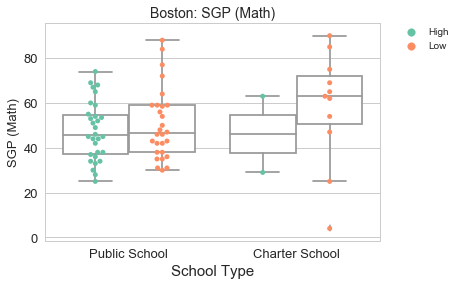

In [137]:
ax = sns.boxplot(x="Org Type", y="SGP (Math)", hue="Residuals Group", data=df_tests_boston, palette=["white", "white"])
ax = sns.swarmplot(x="Org Type", y="SGP (Math)", hue="Residuals Group", data=df_tests_boston, palette="Set2", split=True)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2:4], labels[2:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('SGP (Math)', fontsize=13)
ax.set_title('Boston: SGP (Math)', fontsize=14)
ax.tick_params(labelsize=13)
ax.set_xlabel("School Type", fontsize = 15);

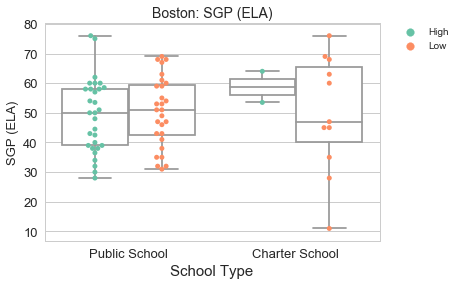

In [138]:
ax = sns.boxplot(x="Org Type", y="SGP (ELA)", hue="Residuals Group", data=df_tests_boston, palette=["white", "white"])
ax = sns.swarmplot(x="Org Type", y="SGP (ELA)", hue="Residuals Group", data=df_tests_boston, palette="Set2", split=True)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2:4], labels[2:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('SGP (ELA)', fontsize=13)
ax.set_title('Boston: SGP (ELA)', fontsize=14)
ax.tick_params(labelsize=13)
ax.set_xlabel("School Type", fontsize = 15);

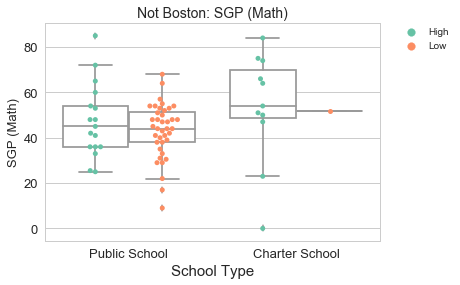

In [140]:
ax = sns.boxplot(x="Org Type", y="SGP (Math)", hue="Residuals Group", data=df_tests_notboston, palette=["white", "white"])
ax = sns.swarmplot(x="Org Type", y="SGP (Math)", hue="Residuals Group", data=df_tests_notboston, palette="Set2", split=True)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2:4], labels[2:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('SGP (Math)', fontsize=13)
ax.set_title('Not Boston: SGP (Math)', fontsize=14)
ax.tick_params(labelsize=13)
ax.set_xlabel("School Type", fontsize = 15);

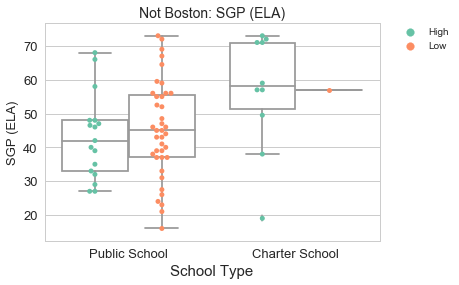

In [141]:
ax = sns.boxplot(x="Org Type", y="SGP (ELA)", hue="Residuals Group", data=df_tests_notboston, palette=["white", "white"])
ax = sns.swarmplot(x="Org Type", y="SGP (ELA)", hue="Residuals Group", data=df_tests_notboston, palette="Set2", split=True)
handles, labels = ax.get_legend_handles_labels()
l = plt.legend(handles[2:4], labels[2:4], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('SGP (ELA)', fontsize=13)
ax.set_title('Not Boston: SGP (ELA)', fontsize=14)
ax.tick_params(labelsize=13)
ax.set_xlabel("School Type", fontsize = 15);

## Final Thoughts & Next Steps

While this dataset is too small to draw any conclusions about the impact of staff demographics, we thought the patterns in suspension data were interesting enough to warrant further investigation. Out-of-school suspensions can be detrimental to students' long-term success in K-12 education, so it may be beneficial to explore whether the racial/ethnic composition of a full school staff is associated with how frequently OSS is used as punishment. 

If we were to continue our investigation, we'd be interested in exploring trends at the school position level and breaking up our 'nonwhite staff' and 'nonwhite student' groups into individual race categories. 